# Index
- Importing Libraries and Data
- Exploratory Data Analysis
    - Feature Data Distributions
    - Correlation Matrices

## Importing and Setting Up Libraries

In [1]:
%%capture
!pip install scikit-learn
!pip install xgboost

In [2]:
import pandas as pd
import os, time
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

In [3]:
base_path = './input/'
data_dir = f'{base_path}/train.csv'
original_data_dir = f'{base_path}/original.csv'

In [4]:
original_df = pd.read_csv(original_data_dir, index_col = 'RowNumber').reset_index(drop=True)
data_df = pd.read_csv(data_dir, index_col="id").reset_index(drop=True)
data_df = pd.concat([data_df, original_df])
data_df = data_df.drop_duplicates().dropna().reset_index(drop=True)

## Exploratory Data Analysis

### Shape and Sample of the Data

In [5]:
print(f'Bank Churn Data Shape: {data_df.shape} \nSample Training Data')
display(data_df.sample(2))

Bank Churn Data Shape: (175030, 13) 
Sample Training Data


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
78222,15728669,Onyemauchechi,751,Germany,Female,35.000,6,"131,908.350",2,1.000,1.000,"6,076.620",1
55294,15646074,Okagbue,694,France,Female,35.000,1,0.000,1,0.000,0.000,"90,906.930",1


## Feature Exploratory DA

### 1. Features: Customer Ids
- Q. Are these unique ids for customers?
- Q. Are there multiple instances of these id? Multiple rows per customer?

In [6]:
cus = data_df.CustomerId.nunique()
l = len(data_df)
print('Average records per customer: ', l/cus)
print('Number of unique customers: ', cus)
print('Number of records:', l)

Average records per customer:  7.473207804961359
Number of unique customers:  23421
Number of records: 175030


### Column wise statistics

In [7]:
# for col in data_df.columns:
#     print(f'Name: {col}. Count of Unique Values: {data_df[col].nunique()}')
#     display(data_df[[col]].describe().reset_index())
#     display(data_df[[col]].sample(5))
#     display(data_df[[col]].value_counts().reset_index().head(15))
#     print('*-'*500)

In [8]:
print('Unique CustomerId values: ', data_df['CustomerId'].nunique())
print('CustomerId Top Frequencies: ')
display(data_df[['CustomerId', 'Surname']].value_counts().reset_index().head())

Unique CustomerId values:  23421
CustomerId Top Frequencies: 


,CustomerId,Surname,count
0,15725679,Hsia,40
1,15726695,Hsia,37
2,15591248,Chukwumaobim,36
3,15657105,Chukwualuka,36
4,15711316,Ch'ang,33


### Feature Summary: 
- Customer Id is the Unique Id for the Customers
- 1 customer may have multiple Ids

### 2. Feature: Surname
- This will mostly have variable values.
- It is unlikely that this will help us in any way

### Encoding Categorical Data

In [9]:
cols_to_encode = ['Geography', 'Gender', 'IsActiveMember', 'HasCrCard', 'NumOfProducts']

for col_to_encode in cols_to_encode:
    data_df = pd.get_dummies(data_df, columns=[col_to_encode], prefix = f'{col_to_encode}_encoded', drop_first=True)
    # , dtype='int'

data_df.head(2)

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_encoded_Germany,Geography_encoded_Spain,Gender_encoded_Male,IsActiveMember_encoded_1.0,HasCrCard_encoded_1.0,NumOfProducts_encoded_2,NumOfProducts_encoded_3,NumOfProducts_encoded_4
0,15674932,Okwudilichukwu,668,33.000,3,0.000,"181,449.970",0,False,False,True,False,True,True,False,False
1,15749177,Okwudiliolisa,627,33.000,1,0.000,"49,503.500",0,False,False,True,True,True,True,False,False


### Dropping CustomerId and Survanme for now.

In [10]:
data_df = data_df.drop(columns = ['CustomerId', 'Surname']).reset_index(drop = True)
display(data_df.sample(2))

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_encoded_Germany,Geography_encoded_Spain,Gender_encoded_Male,IsActiveMember_encoded_1.0,HasCrCard_encoded_1.0,NumOfProducts_encoded_2,NumOfProducts_encoded_3,NumOfProducts_encoded_4
71372,696,27.000,3,0.000,"149,892.790",0,False,False,True,True,True,False,False,False
41371,662,43.000,3,0.000,"120,107.100",0,False,False,True,False,True,True,False,False


## Feature Data Distribution

#### - Target Class Distribution

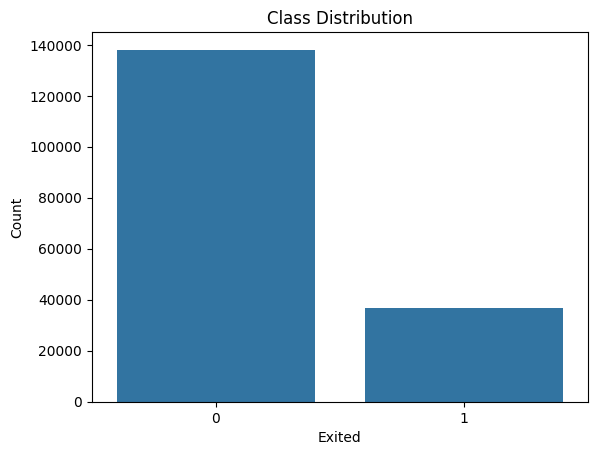

In [11]:
sns.countplot(x='Exited', data = data_df)
plt.title('Class Distribution')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.show()

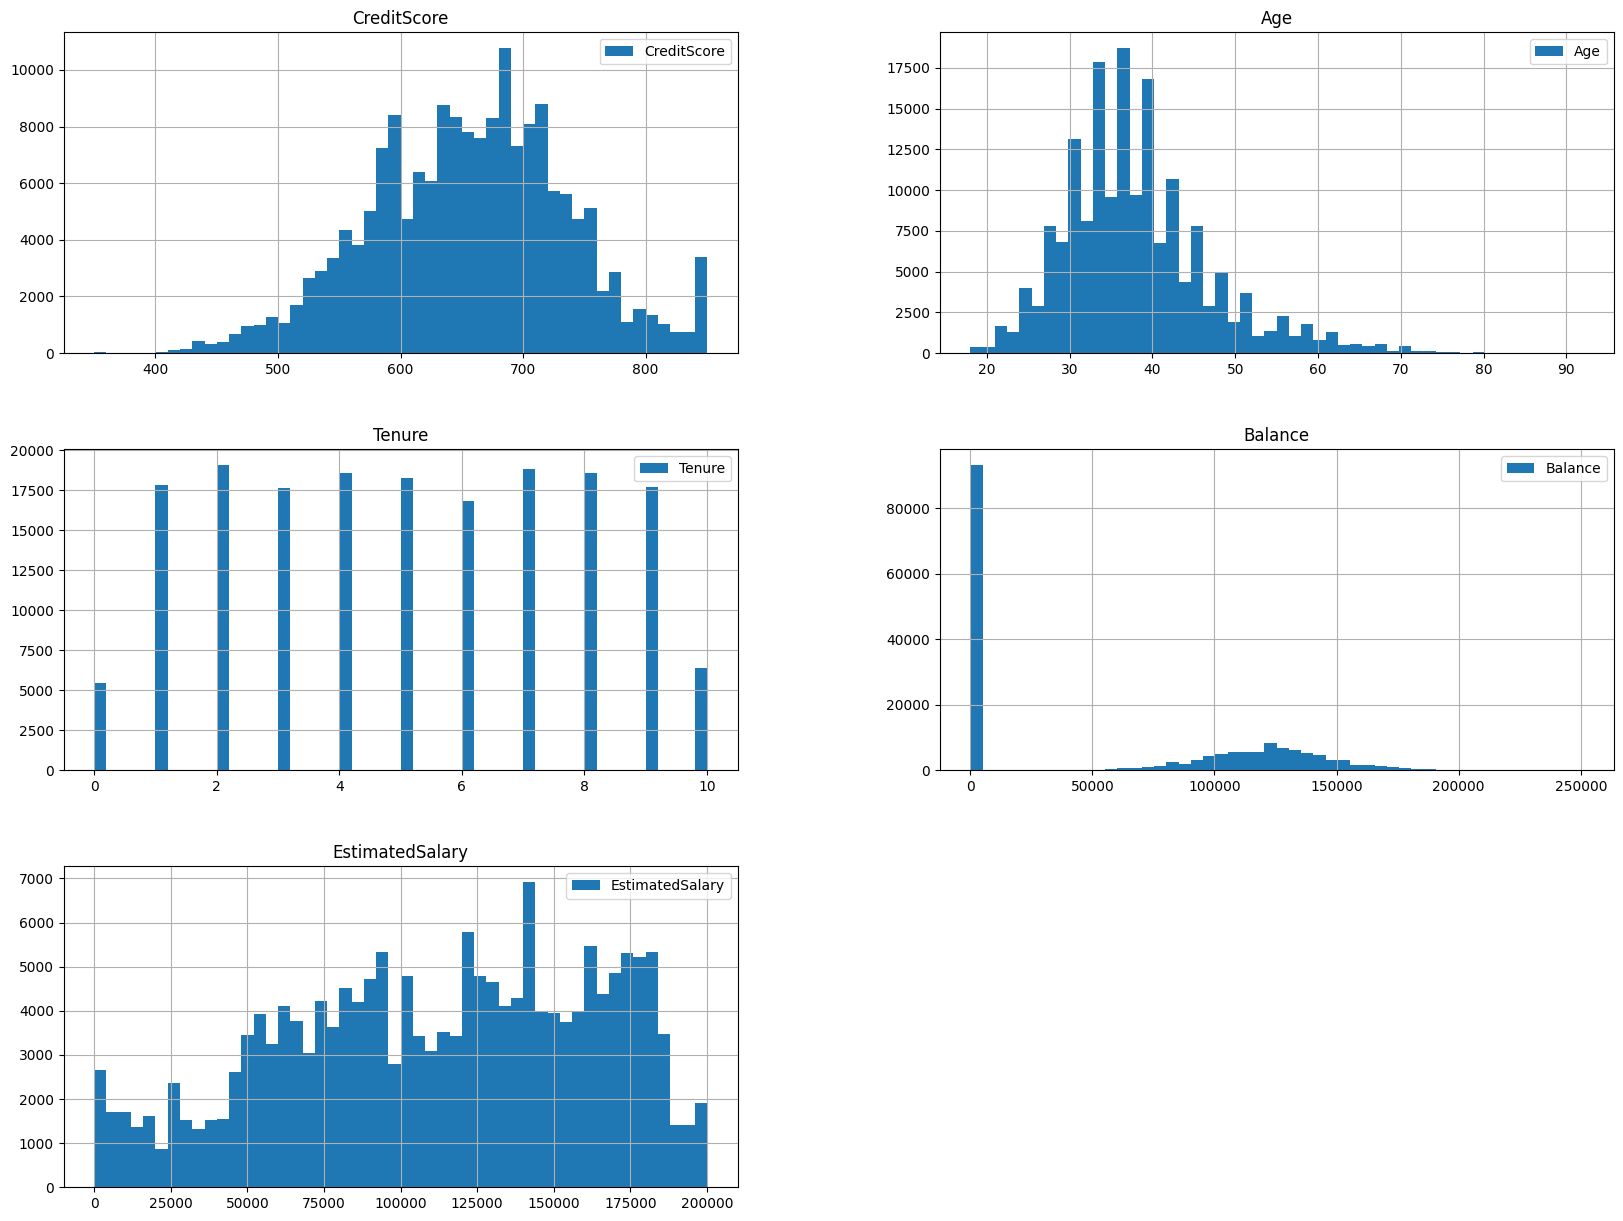

In [12]:
data_df.drop(columns = 'Exited').hist(bins=50, figsize=(20,15), legend = True)
plt.show()

### - Correlation Matrix

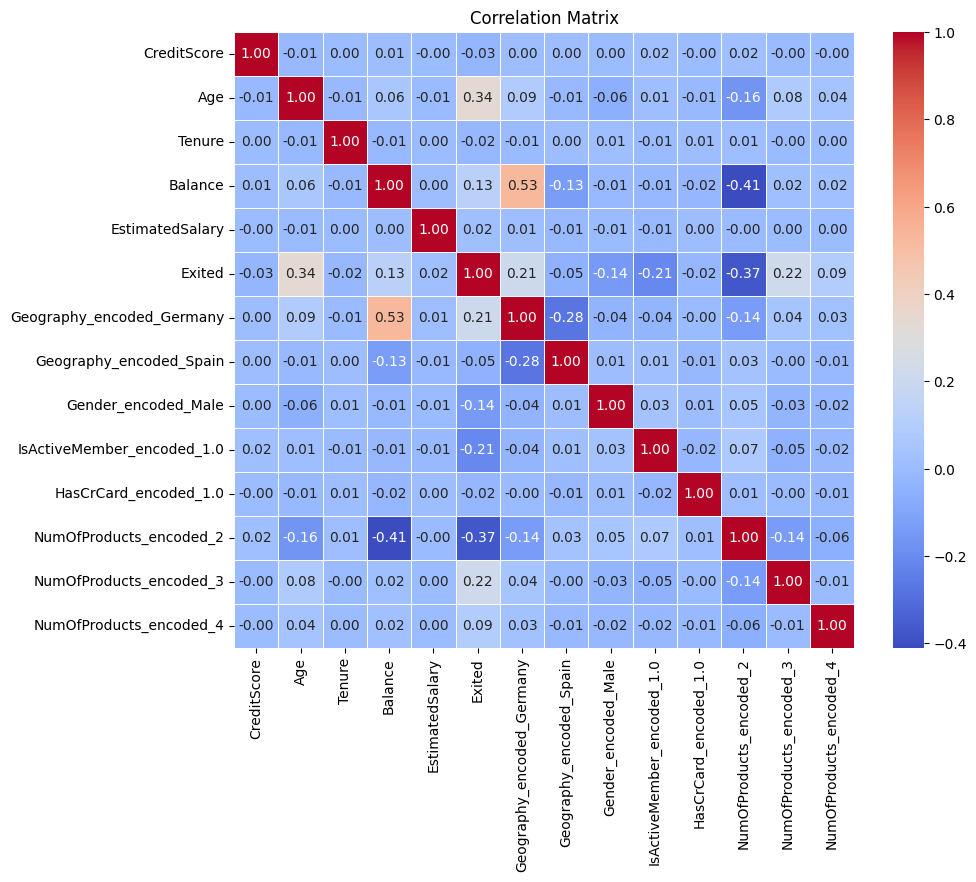

In [13]:
correlation_matrix = data_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

## Importing Libraries

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from random import randint

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Model Run Pipeline

In [15]:
def confusion_matrix_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
def metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    
    # Convert classification report to DataFrame
    df_classification_report = pd.DataFrame(classification_rep).transpose()
    
    # Add AUC and Accuracy to the DataFrame
    df_metrics = pd.DataFrame({
        'AUC Score': [auc],
        'Accuracy': [accuracy]
    })

    
    display(df_metrics)
    display(df_classification_report)
    confusion_matrix_plot(y_test, y_pred)
    
def sklearn_pipeline(model, x_train, y_train, x_test, y_test, is_binary=True):
    pipeline = make_pipeline(StandardScaler(), model)
    
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    if not is_binary:
        y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_real]

    metrics(y_test, y_pred)

def run_models(models, x_train, y_train, x_test, y_test, is_binary=True):
    for model in models:
        print(f"Running {type(model).__name__}:")
        sklearn_pipeline(model, x_train, y_train, x_test, y_test, is_binary)
        print("\n\n")

## Dividing the Data (Random Sampling)

In [16]:
x = data_df.drop(columns = ['Exited'])
y = data_df['Exited']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


## Model Runs

Running LogisticRegression:


,AUC Score,Accuracy
0,0.725,0.855


,precision,recall,f1-score,support
0,0.877,0.949,0.911,"27,614.000"
1,0.725,0.501,0.593,"7,392.000"
accuracy,0.855,0.855,0.855,0.855
macro avg,0.801,0.725,0.752,"35,006.000"
weighted avg,0.845,0.855,0.844,"35,006.000"


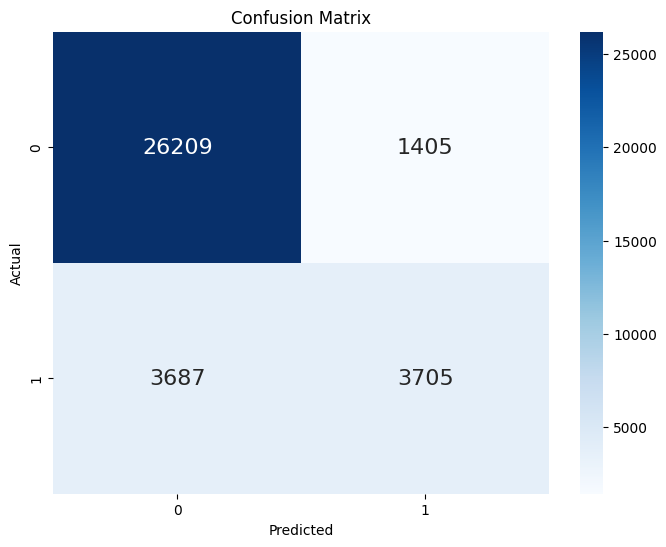




Running RandomForestClassifier:


,AUC Score,Accuracy
0,0.734,0.854


,precision,recall,f1-score,support
0,0.882,0.941,0.910,"27,614.000"
1,0.706,0.527,0.604,"7,392.000"
accuracy,0.854,0.854,0.854,0.854
macro avg,0.794,0.734,0.757,"35,006.000"
weighted avg,0.845,0.854,0.846,"35,006.000"


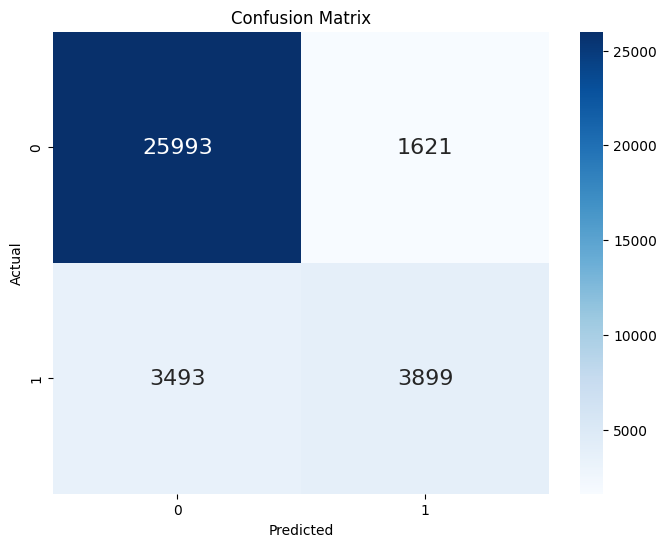




Running DecisionTreeClassifier:


,AUC Score,Accuracy
0,0.696,0.797


,precision,recall,f1-score,support
0,0.872,0.870,0.871,"27,614.000"
1,0.518,0.522,0.520,"7,392.000"
accuracy,0.797,0.797,0.797,0.797
macro avg,0.695,0.696,0.696,"35,006.000"
weighted avg,0.797,0.797,0.797,"35,006.000"


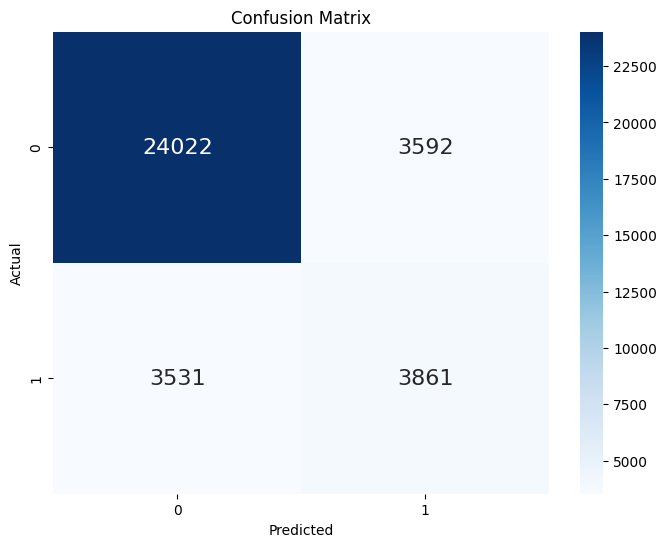




Running KNeighborsClassifier:


,AUC Score,Accuracy
0,0.733,0.849


,precision,recall,f1-score,support
0,0.882,0.933,0.907,"27,614.000"
1,0.680,0.534,0.598,"7,392.000"
accuracy,0.849,0.849,0.849,0.849
macro avg,0.781,0.733,0.753,"35,006.000"
weighted avg,0.839,0.849,0.842,"35,006.000"


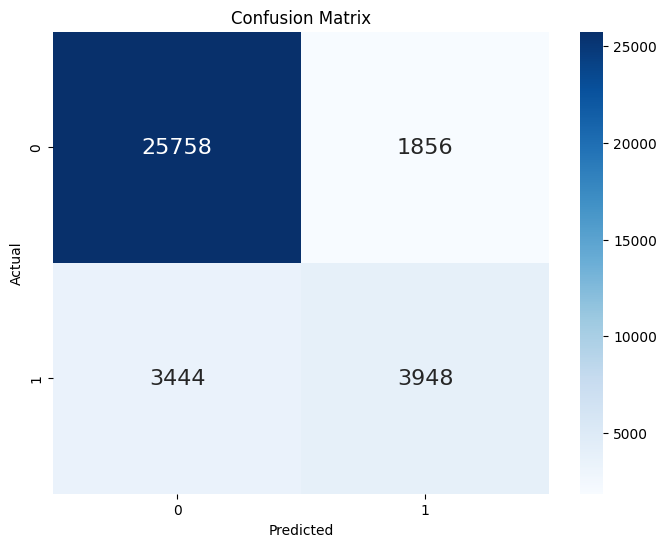

In [17]:
models = [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=5)]
run_models(models, x_train, y_train, x_test, y_test)

In [18]:
# plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_real, 'Predicted_Class': y_pred})

# plt.figure(figsize=(8, 6))
# sns.histplot(data=plot_data, x='Actual', y='Predicted', bins=50, cmap='viridis', cbar=True)
# plt.title(f'Scatter Heatmap: Predicted vs Observed Data (R^2 = {r_sq.round(3)})')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.show()



# plt.figure(figsize=(8, 6))
# sns.histplot(data=plot_data, x='Actual', y='Predicted_Class', bins=50, cmap='viridis', cbar=True)
# plt.title(f'Scatter Heatmap: Classified vs Observed Data (Accuracy = {round(accuracy,3)})')
# # Adding a big hollow circle at (0, 0)
# plt.scatter(0, 0, marker='o', facecolors='none', edgecolors='red', s=200, linewidths=2)

# # Adding a big hollow circle at (1, 1)
# plt.scatter(1, 1, marker='o', facecolors='none', edgecolors='blue', s=200, linewidths=2)

# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')


# plt.show()


# plt.scatter(y_test, y_pred_real, color='blue', label='Observed vs Predicted')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Fit')

# # Adding labels and title
# plt.xlabel('Observed Values')
# plt.ylabel('Predicted Values')
# plt.title('Observed vs Predicted Values')
# plt.legend()

# # Show the plot
# plt.show()



# plt.figure(figsize=(8, 6))
# plt.plot([x for x in range(1,len(accuracies) + 1)], accuracies, marker='o', linestyle='-')
# plt.title('Accuracy vs. Number of Features')
# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')
# plt.grid(True)
# plt.show()


In [19]:
# y = train_df['Exited']
# x = train_df.drop(columns = ['Exited'])
# accuracies = []

# for i in range(1, 1 + x.shape[1]):
    
#     x_prime = x.iloc[:,:i]
    
#     x_train, x_test, y_train, y_test = train_test_split(x_prime, y, test_size=0.2, random_state=42)
#     model = train(x_train, y_train)
#     r_sq = model.score(x_train, y_train)
    
#     y_pred, y_pred_real = test(model, x_test, y_test)
    
#     accuracy = accuracy_score(y_test, y_pred)
#     accuracies.append(accuracy)


In [20]:
# coefficients = model.coef_

# # Assuming your feature names are stored in a list called 'feature_names'
# # Pair feature names with their coefficients and sort by coefficient value
# feature_rankings = sorted(zip(list(x.columns), coefficients), key=lambda x: abs(x[1]), reverse=True)

# i = 1
# for feature, coefficient in feature_rankings:
#     # print(f"Column Name:{feature}, Rank: {i}")
#     print(f"{i}. {feature}")
#     i += 1

## xgboost Model

,AUC Score,Accuracy
0,0.751,0.865


,precision,recall,f1-score,support
0,0.888,0.949,0.917,"27,614.000"
1,0.742,0.554,0.635,"7,392.000"
accuracy,0.865,0.865,0.865,0.865
macro avg,0.815,0.751,0.776,"35,006.000"
weighted avg,0.857,0.865,0.858,"35,006.000"


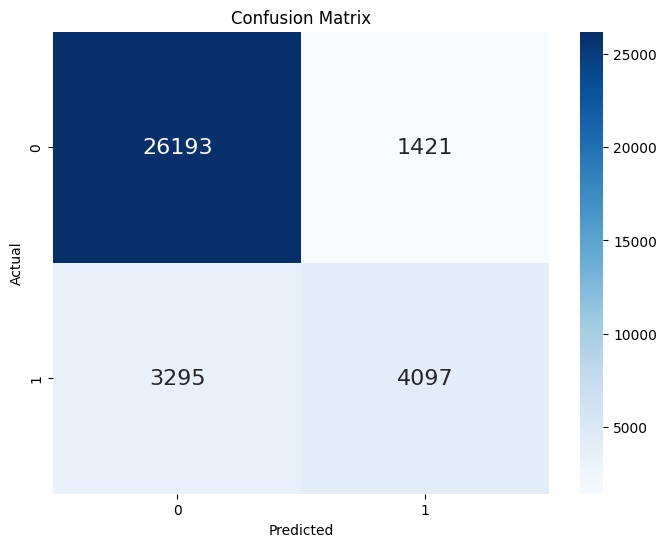

In [21]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)
metrics(y_test, y_pred)

### XGB with Hyperparameter Tuning

In [22]:
# xgb_param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.05, 0.01, 0.1],
#     'gamma': [0, 0.25, 1.0],
#     'reg_lambda': [0, 1.0, 10.0],
#     'scale_pos_weight': [1, 3, 5]
# }

# optimal_parameters = GridSearchCV(
#     estimator = xgb.XGBClassifier(objective='binary:logistic',
#                                 seed=42,
#                                 subsample=0.9,
#                                 colsample_bytree=0.5),
#                                 param_grid=xgb_param_grid,
#                                 scoring='roc_auc',
#                                 n_jobs=10,
#                                 cv=3
#                             )

# optimal_parameters.fit(x_train,
#                        y_train)

# print(f'Best params: {optimal_parameters.best_params_}')

,AUC Score,Accuracy
0,0.805,0.832


,precision,recall,f1-score,support
0,0.929,0.852,0.889,"27,614.000"
1,0.578,0.757,0.656,"7,392.000"
accuracy,0.832,0.832,0.832,0.832
macro avg,0.754,0.805,0.772,"35,006.000"
weighted avg,0.855,0.832,0.840,"35,006.000"


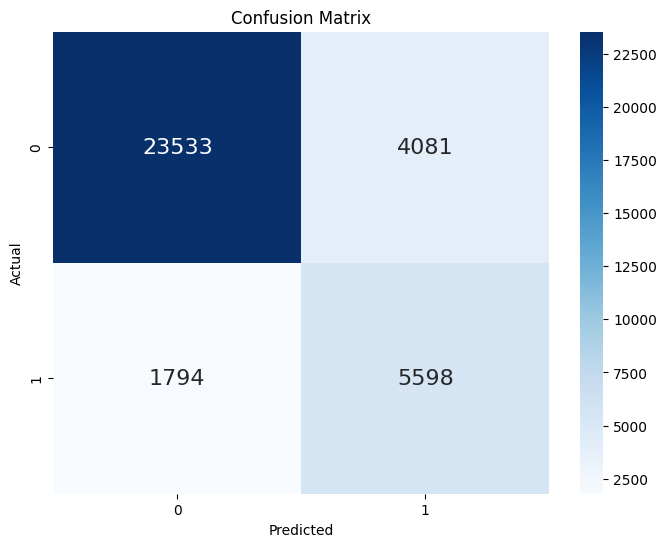

In [23]:
best_xgboost_params = {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}
model_xgb = xgb.XGBClassifier(objective='binary:logistic', **best_xgboost_params, seed=42)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)
metrics(y_test, y_pred)

### Random Forest with Hyperparameter Tuning:

In [24]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}



# Create a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Instantiate the GridSearchCV object
random_search = RandomizedSearchCV(rf_model, param_distributions=random_grid, n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs = -1)

# Perform grid search
random_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters on the test set
best_rf_model = random_search.best_estimator_

y_pred = best_rf_model.predict(x_test)

metrics(y_test, y_pred)


KeyboardInterrupt



### KNN with with Hyperparameter Tuning:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid to search
param_dist = {
    'n_neighbors': randint(1, 20),  # Adjust the range based on your problem
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}


# Create a KNN classifier
knn_model = KNeighborsClassifier()

# Instantiate the GridSearchCV object
random_search = RandomizedSearchCV(estimator=knn_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)

# Perform grid search
random_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
best_knn_model = random_search.best_estimator_
y_pred = best_knn_model.predict(x_test)

metrics(y_test, y_pred)